# KNN(K-Nearest-Neibor) 分類
```
1. 步驟:
    1. 決定k
    2. 以未知的資料點維中心, 找出最近的k點資料, 西瓜偎大邊, 這k點中假設有3類, 挑數量最大的一類, 此資料就被分為那個類別
    3. sklearn的knn有加入權重, 距離太遠的的權重會降低, 請參考圖2
2. 算距離的方式要依據情況決定, 文章分類就是用 cosine distance, 一般地圖幾何就用 euclidien distance
3. 參考資料
    http://www.slideshare.net/ssuserf88631/knn-51511604
    http://ihong-blog.logdown.com/posts/413527-knn-classification-algorithm
        
```

In [114]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors.classification:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`k_neighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [c

圖1


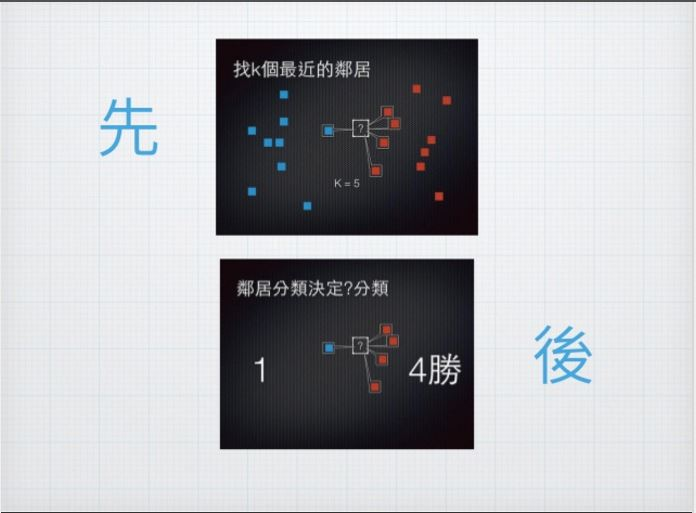

In [4]:
from IPython.display import Image
print('圖1')
Image('knn1.jpg')

圖2


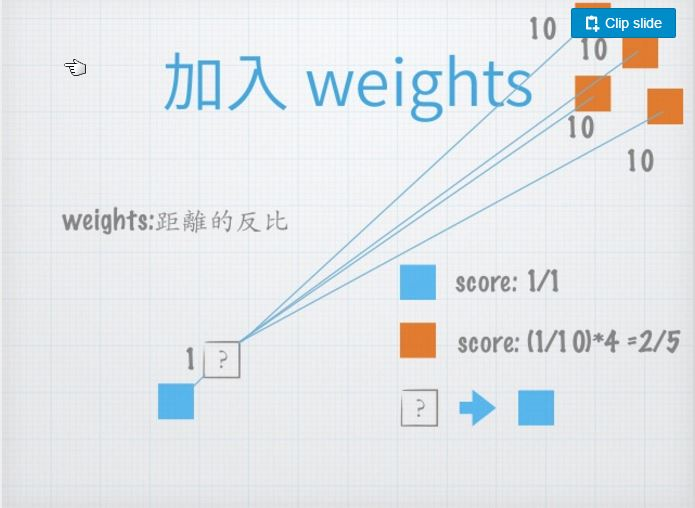

In [3]:
from IPython.display import Image
print('圖2')
Image('knn2.jpg')

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = '.'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')
ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 抓出頻果新聞資料
apple36Df, apple78Df = None, None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
    
    apple36Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160301_20160630_02
         order by batchno
    ''', sklearnConn)
apple36Df.head()

,forum,subject,term,keyword,content,pageurl
0,strange,農婦打噴嚏燒傷8頭驢 20萬飛了,山東 劉姓 農婦 打火機 編號 掛牌 噴嚏 倒楣 驢子 燒傷 人民幣 台幣 中國 齊魯 報導...,驢子 驢子 驢子 驢子 驢子 驢子 驢子 農婦 農婦 農婦 農婦 噴嚏 噴嚏 噴嚏 紋身 紋...,山東一名劉姓農婦，日前在用打火機替家中飼養的毛驢掛上編號掛牌時，忍不住打了個噴嚏，沒想到手一...,http://www.appledaily.com.tw/realtimenews/arti...
1,strange,最新款007座駕 日內瓦展前曝光,形象 英國 martin 旗下 十二 跑車 消息 國外 媒體 瑞士 時間 日內瓦 車展 推出...,車展 車展 新款 新款 優雅 優雅 力表 過動 渦輪引擎 曝光 曝光 渦輪 元則 端倪 ma...,形象與007專屬座駕密不可分的英國Aston Martin，旗下行之有年的DB9十二缸跑車，...,http://www.appledaily.com.tw/realtimenews/arti...
2,strange,上班族好無奈 最怕同事這些壞習慣,職場 同事 百款 上班族 星期 同事 時間 小時 小心 衛生習慣 公德心 習慣 同事 報導 ...,冰箱 冰箱 冰箱 同事 同事 同事 生氣 生氣 衛生習慣 百款 大吼大叫 易怒 公德心 公用...,職場同事百百款，身為一位上班族，一星期有5天必須跟同事見面，每天相處時間還得要8小時以上，如...,http://www.appledaily.com.tw/realtimenews/arti...
3,strange,【占卜】你為什麼想分手？,單身 相愛 分手 原因 家庭 壓力 第三者 金錢 工作 老師 數字 占卜 分手 原因 楊婷 ...,分手 分手 分手 分手 愛情 愛情 愛情 相愛 相愛 資料 資料 資料 資料 照片 照片 照...,你恢復單身了嗎？相愛容易相處難，會讓你想分手的原因是什麼呢？是家庭壓力、第三者、金錢還是工作...,http://www.appledaily.com.tw/realtimenews/arti...
4,strange,【旅途中】櫻花叢中的小精靈,櫻花 季節 發現 櫻花 雙活 眼睛 棲蘭 武陵農場 意外 漂亮 實在 可愛 小精靈 棲蘭 國...,棲蘭 棲蘭 櫻花 櫻花 櫻花 畫眉 畫眉 武陵農場 武陵農場 賞櫻 賞櫻 親子 親子 雙活 ...,春暖花開，又到了追櫻花的季節，有沒有發現粉嫩粉嫩的櫻花，幾雙活靈活現的的眼睛在盯著呢？愛玩姐...,http://www.appledaily.com.tw/realtimenews/arti...


In [115]:
# train knn model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_distances
from sklearn import metrics


clf = KNeighborsClassifier(algorithm='ball_tree', weights='distance')
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.term)
clf.fit(trainMx, apple36Df.forum)
trainMx, vec

(<88753x113312 sparse matrix of type '<type 'numpy.float64'>'
 	with 5118516 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None))

In [33]:
# 沒想到fit 3萬多筆不會爆記憶體, predict的時候超級吃記憶體, 才5000筆就炸記憶體, 這個區塊不要執行...

# base = apple78Df[:5000]
# predicted = clf.predict(vec.transform(base.term))
# print(metrics.classification_report(base.forum, predicted, target_names=clf.classes_))
# pd.DataFrame(columns=clf.classes_, index=clf.classes_, data=metrics.confusion_matrix(base.forum, predicted))

ValueError: Found input variables with inconsistent numbers of samples: [2000, 1000]

In [116]:
# 用batch的方式慢慢predict apple 7~ 8月的資料, 看分數果然滿差的, 因為不是用 cosin distance
batch = 1000
predicted = []
for datapoint in range(0, len(apple78Df), batch):
    up = datapoint + batch
    predicted += clf.predict(vec.transform(apple78Df[datapoint : up if up < len(apple78Df) else len(apple78Df)].term)).tolist()
    
print(metrics.classification_report(apple78Df.forum, predicted, target_names=clf.classes_))
pd.DataFrame(columns=clf.classes_, index=clf.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

               precision    recall  f1-score   support

           3c       0.48      0.64      0.55       734
       animal       0.76      0.64      0.69       673
entertainment       0.79      0.73      0.76      3082
      fashion       0.77      0.67      0.72       649
      finance       0.77      0.75      0.76      3201
        forum       0.33      0.19      0.24      1052
international       0.72      0.68      0.70      7579
         life       0.63      0.69      0.66      7029
        local       0.64      0.71      0.67      4971
     politics       0.69      0.60      0.64      2543
     property       0.73      0.70      0.72       551
       sports       0.85      0.88      0.87      3441
      strange       0.34      0.41      0.37      1120

  avg / total       0.69      0.68      0.68     36625



,3c,animal,entertainment,fashion,finance,forum,international,life,local,politics,property,sports,strange
3c,468,11,10,2,68,1,21,84,22,1,0,8,38
animal,2,428,17,0,0,5,67,60,31,3,0,7,53
entertainment,26,6,2236,52,24,36,185,172,143,26,5,59,112
fashion,4,3,108,437,5,3,29,13,10,1,0,3,33
finance,128,0,14,5,2413,22,183,219,77,46,26,36,32
forum,12,2,19,1,46,203,242,220,104,157,3,26,17
international,130,36,121,25,185,90,5136,587,631,115,18,238,267
life,138,32,161,14,182,99,376,4815,627,199,42,80,264
local,19,13,44,7,87,52,312,666,3526,119,38,28,60
politics,11,1,13,0,72,90,273,316,203,1527,6,27,4


In [113]:
# 用鳶尾花資料每個類別前30個當train data, 後面20筆資料當test data

import numpy as np
import pylab as pl
from sklearn import neighbors, datasets

# import some data to play with
iris = datasets.load_iris()
X = np.r_[tuple(iris.data[p:p + 30] for p in range(0, len(iris.data), 50))]
Y = np.r_[tuple(iris.target[p:p + 30] for p in range(0, len(iris.target), 50))]
testX = np.r_[tuple(iris.data[p + 30:p + 50] for p in range(0, len(iris.data), 50))]
testY = np.r_[tuple(iris.target[p + 30:p + 50] for p in range(0, len(iris.target), 50))]

knn=neighbors.KNeighborsClassifier()
knn.fit(X, Y)
pred = knn.predict(testX)
print('accuracy:', metrics.accuracy_score(testY, pred))
print(metrics.confusion_matrix(testY, pred))

accuracy: 0.983333333333
[[20  0  0]
 [ 0 19  1]
 [ 0  0 20]]


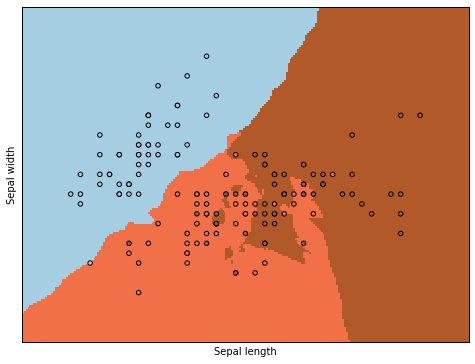

In [46]:
# 官網的資料: 用鳶尾花資料當範例, 不過只有取前兩個維度, 而且

# Code source: Gael Varoqueux
# Modified for Documentation merge by Jaques Grobler
# License: BSD

import numpy as np
import pylab as pl
from sklearn import neighbors, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features. 
Y = iris.target


h = .02 # step size in the mesh

knn=neighbors.KNeighborsClassifier()

# we create an instance of Neighbours Classifier and fit the data.
knn.fit(X, Y)

# Plot the decision boundary. For that, we will asign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z_ = Z.reshape(xx.shape)
pl.figure(1, figsize=(8, 6))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx, yy, Z_)

# Plot also the training points
pl.scatter(X[:,0], X[:,1],c=Y )
pl.xlabel('Sepal length')
pl.ylabel('Sepal width')

pl.xlim(xx.min(), xx.max())
pl.ylim(yy.min(), yy.max())
pl.xticks(())
pl.yticks(())

pl.show()